In [1]:
import numpy as np
from scipy.integrate import odeint

def lotka_volterra_system(
    states: list[float],
    time: np.array,
    *parameters: tuple[float, float, float, float],
) -> np.ndarray:
    """
    Parameters
    ----------
    states : list[float]
        A list of the current states of the system.
        states[0] - prey, states[1] - predator

    time : np.ndarray
        simulation time array
    *parameters : tuple[float, float, float, float]
        The parameters of the model: alpha, beta, delta, gamma
        alpha: growth rate of prey population
        beta: death rate of prey population
        delta: growth rate of predator population
        gamma: death rate of predator population

    Returns
    -------
    np.ndarray
        The derivatives of the states with respect to time.
    """
    alpha, beta, gamma, delta = parameters

    xdot = np.array(
        [
            states[0] * (alpha - beta * states[1]),
            states[1] * (-gamma + states[0] * delta),
        ]
    )
    return xdot


def run_lv(x0, times, parameter_samples) -> None:
    """
    Runs the RLC model for a specified number of drift windows.
    Uses the initial state, the drift windows, the times, the get_parameters and save_output methods of the class
    to integrate the system of ODEs and save the output for each window.

    Parameters
    ----------
    self : object
        The instance of the class
    """
    return odeint(lotka_volterra_system, x0, times, args=parameter_samples)

# Baseline
lv_p1 = [
    1.1,  # alpha - prey growth rate
    0.4,  # beta - prey death rate
    0.5,  # gamma - predator death rate
    0.1,  # delta - predator growth rate
]

# Increase in death rate of prey
lv_p2 = [
    1.1,  # alpha - prey growth rate
    0.7,  # beta - prey death rate
    0.5,  # gamma - predator death rate
    0.1,  # delta - predator growth rate
]

lv1_param_mins = 4*[0.]

### CASE: 1-Parameter No-Drift

#### <center> Select Seed & Run Model <center>

In [2]:
#     Seeds
# initial Measure Outcomes
#------------------------
# (4431, 1394)      pretty good
# (629449, 281824)  good
# (590903, 655235)  pretty good
# (997469, 279770)  okay (bad E(r) to good estimate match)
# (581506, 895913)  best

# lv1_initial_seed = np.random.randint(0, 10e5)
# lv1_measurement_seed = np.random.randint(0, 10e5)

lv1_initial_seed = 581506
lv1_measurement_seed =  895913

In [3]:
from pydci import Model
import importlib

importlib.reload(Model)

lv1_true_param = lv_p1
x0 = np.array([2, 4])
param_shifts = None  # {17: lv_p2}

lvm_model = Model.DynamicModel(
    run_lv,
    x0,
    lv1_true_param,
    measurement_noise=0.1,
    solve_ts=0.3,
    sample_ts=1,
    diff=0.15,
    param_mins=lv1_param_mins,
    param_shifts=param_shifts,
)

state_df, _ = lvm_model.forward_solve(0, 5)
state_df

,ts,shift_idx,sample_flag,true_param_0,true_param_1,true_param_2,true_param_3,true_vals_0,true_vals_1,obs_vals_0,obs_vals_1
0,0.000000,0,True,1.1,0.4,0.5,0.1,2.000000,4.000000,2.173050,4.107219
1,0.333333,0,False,1.1,0.4,0.5,0.1,1.738621,3.602262,NaN,NaN
2,0.666667,0,False,1.1,0.4,0.5,0.1,1.592117,3.222438,NaN,NaN
3,1.000000,0,True,1.1,0.4,0.5,0.1,1.530745,2.872868,1.701773,2.830664
4,1.333333,0,False,1.1,0.4,0.5,0.1,1.538345,2.559002,NaN,NaN
5,1.666667,0,False,1.1,0.4,0.5,0.1,1.608060,2.282386,NaN,NaN
6,2.000000,0,True,1.1,0.4,0.5,0.1,1.739800,2.042502,1.689288,2.201428
7,2.333333,0,False,1.1,0.4,0.5,0.1,1.938911,1.837896,NaN,NaN
8,2.666667,0,False,1.1,0.4,0.5,0.1,2.215559,1.666895,NaN,NaN
9,3.000000,0,True,1.1,0.4,0.5,0.1,2.584481,1.528086,2.529334,1.477870


In [4]:
from pydci import SequentialMUDProblem
import importlib

importlib.reload(SequentialMUDProblem)

<module 'pydci.SequentialMUDProblem' from '/home/jupyter/MyData/repos/pyDCI/src/pydci/SequentialMUDProblem.py'>

In [5]:
lv1_param_mins = [0, 0, 0, 0]

lvm_prob = SequentialMUDProblem.SequentialMUDProblem(
    lvm_model,
    diff=0.5,
    param_mins=lv1_param_mins,
)

In [6]:
samples = lvm_prob.get_initial_samples(1000)
samples

array([[1.16121361, 0.39918623, 0.40456401, 0.06366092],
       [0.90838782, 0.48301175, 0.2942672 , 0.13415601],
       [1.56222586, 0.49475948, 0.7451628 , 0.1166529 ],
       ...,
       [1.29557614, 0.50189384, 0.44925049, 0.07629887],
       [1.31041284, 0.50653988, 0.52225579, 0.144134  ],
       [1.17935466, 0.50929083, 0.35732079, 0.10247122]])

In [38]:
state_df, pfs = lvm_model.forward_solve(0, 5, samples=samples)
state_df

Solving model for samples: |████████████████████| 1000/1000 [100%] in 0.4s (2340


,ts,shift_idx,sample_flag,true_param_0,true_param_1,true_param_2,true_param_3,true_vals_0,true_vals_1,obs_vals_0,obs_vals_1
0,0.000000,0,True,1.1,0.4,0.5,0.1,2.000000,4.000000,2.033302,4.171615
1,0.333333,0,False,1.1,0.4,0.5,0.1,1.738621,3.602262,NaN,NaN
2,0.666667,0,False,1.1,0.4,0.5,0.1,1.592117,3.222438,NaN,NaN
3,1.000000,0,True,1.1,0.4,0.5,0.1,1.530745,2.872868,1.421444,2.903194
4,1.333333,0,False,1.1,0.4,0.5,0.1,1.538345,2.559002,NaN,NaN
5,1.666667,0,False,1.1,0.4,0.5,0.1,1.608060,2.282386,NaN,NaN
6,2.000000,0,True,1.1,0.4,0.5,0.1,1.739800,2.042502,1.702943,2.137332
7,2.333333,0,False,1.1,0.4,0.5,0.1,1.938911,1.837896,NaN,NaN
8,2.666667,0,False,1.1,0.4,0.5,0.1,2.215559,1.666895,NaN,NaN
9,3.000000,0,True,1.1,0.4,0.5,0.1,2.584481,1.528086,2.615510,1.592048


In [39]:
pfs.shape

(1000, 16, 2)

In [40]:

q_lam.shape

(1000, 12)

In [41]:
lam = samples
lam.shape

(1000, 4)

In [42]:
from pydci.utils import get_df
data = get_df(state_df.loc[state_df['sample_flag']], 'true_vals', size=2)
data = data.reshape(-1,1)

In [43]:
from pydci.MUDProblem import MUDProblem

mud_prob = MUDProblem(lam, q_lam, data, 0.4, max_nc=2)
mud_prob.mud_point(), mud_prob.expected_ratio()

(array([0.90237287, 0.30606819, 0.57913017, 0.12803806]), 0.8188864035712081)

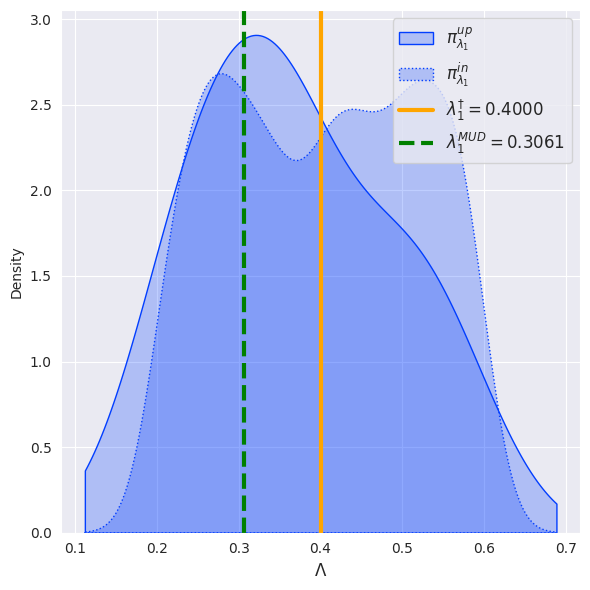

In [44]:
ax = mud_prob.plot_param_state(param_idxs=[1], plot_initial=True, true_vals=[lv_p1])

In [14]:
mud_prob.state

,lam_0,lam_1,lam_2,lam_3,q_lam_0,q_lam_1,q_lam_2,q_lam_3,q_lam_4,q_lam_5,...,weight,pi_in,pi_pr,pi_obs,ratio,pi_up,q_pca_0,q_pca_1,q_pca_2,q_pca_3
0,1.427299,0.339321,0.671997,0.061119,1.837287,3.793999,2.841985,2.217006,0.0,0.0,...,1.0,27.788270,0.000013,0.000000e+00,0.000000e+00,0.000000e+00,45.994186,-49.401078,-4.847109,-9.395373
1,0.909912,0.573524,0.600114,0.131737,2.052615,3.851719,0.829586,2.497140,0.0,0.0,...,1.0,42.381180,0.000424,1.654307e-36,3.901241e-33,1.653392e-31,-8.150941,8.858998,2.279701,2.703908
2,0.656736,0.242167,0.630316,0.080009,1.698964,3.998321,1.530811,2.412345,0.0,0.0,...,1.0,31.461233,0.000084,6.834743e-04,8.113928e+00,2.552742e+02,-2.360522,-1.038942,0.750602,-0.101313
3,0.939525,0.421525,0.338866,0.083300,1.911966,4.086377,1.035190,3.268937,0.0,0.0,...,1.0,54.277773,0.000563,1.368383e-49,2.430209e-46,1.319063e-44,-4.919585,13.424473,2.746648,2.389918
4,1.128289,0.201097,0.440433,0.075173,2.022491,4.054525,3.057247,3.141899,0.0,0.0,...,1.0,26.008222,0.000026,1.087753e-247,4.109331e-243,1.068764e-241,28.656530,-17.044086,-2.072745,-3.736773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.592775,0.574785,0.621704,0.080240,2.059953,3.908338,1.696610,2.414081,0.0,0.0,...,1.0,29.341468,0.000065,1.717862e-243,2.635255e-239,7.732224e-238,13.682420,-29.225946,-5.450851,-6.288592
996,1.101548,0.387912,0.709667,0.140037,2.123612,4.011076,1.814110,2.565021,0.0,0.0,...,1.0,41.814192,0.000276,4.282885e-27,1.549539e-23,6.479271e-22,5.300369,-8.980750,-1.676255,-1.587834
997,0.566940,0.447761,0.631348,0.114927,2.024617,3.811680,0.907226,2.359120,0.0,0.0,...,1.0,26.278191,0.000178,1.356974e-44,7.612363e-41,2.000391e-39,-8.798292,9.967014,2.781148,3.190514
998,1.039126,0.518001,0.591217,0.136846,1.827635,4.010088,0.931422,2.635492,0.0,0.0,...,1.0,48.092111,0.000306,3.361065e-19,1.099798e-15,5.289161e-14,-6.186465,5.902628,1.749568,1.244127


In [15]:
mud_prob.expected_ratio()

0.49727887768427614